In [172]:
import yaml
import random
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
from torchvision.transforms import functional as F
import torch.nn as nn

from vit import ViTBackbone, ClassificationHead

In [173]:
with open("configs.yaml", "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

cfg_model = cfg['model']
cfg_train = cfg['training']

device = torch.device("cuda")

### Load Val Dataset

In [174]:
mean = 0.5443
std = 0.1946

data_path = 'data'
batch_size = 1
num_workers = 16

In [175]:
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [176]:
full_dataset = datasets.ImageFolder(
    root=data_path, transform=test_transform
)

total_size = len(full_dataset)
train_size = int(0.8 * total_size)
test_size  = total_size - train_size

_, test_dataset = random_split(
    full_dataset, [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

In [177]:
test_loader = DataLoader(
    test_dataset,  batch_size=batch_size,
    shuffle=False, num_workers=num_workers
)

### Model

In [178]:
vit_backbone = ViTBackbone(
    in_channels=cfg_model["vit"]["in_channels"],
    embedding_dim=cfg_model["vit"]["embedding_dim"],
    patch_size=cfg_model["vit"]["patch_size"],
    max_patch_num=cfg_model["vit"]["max_patch_num"],
    L=cfg_model["vit"]["depth"],
    n_heads=cfg_model["vit"]["n_heads"],
    mlp_size=cfg_model["vit"]["mlp_size"]
)
classifier = ClassificationHead(
    embedding_dim=cfg_model["vit"]["embedding_dim"],
    n_classes=cfg_model["cls"]["n_classes"]
)

In [179]:
vit_backbone.load_state_dict(
    torch.load(cfg["model_weights"]["vit_backbone"])
)
classifier.load_state_dict(
    torch.load(cfg["model_weights"]["classifier"])
)

model = nn.Sequential(
    vit_backbone,
    classifier
)
model = model.to(device)

### Inference

In [180]:
samples_num = 4
max_idx = 1000

images, pred_labels, real_labels = [], [], []
rand_idxs = random.sample(range(max_idx), samples_num)
k = 0

model.eval()
with torch.no_grad():
    for b_idx, (image, label) in enumerate(test_loader):
        if b_idx >= max_idx:
            break
        if b_idx in rand_idxs:
            images.append(image[0])
            pred_labels.append(torch.argmax(model(image.to(device))[0]))
            real_labels.append(label[0])

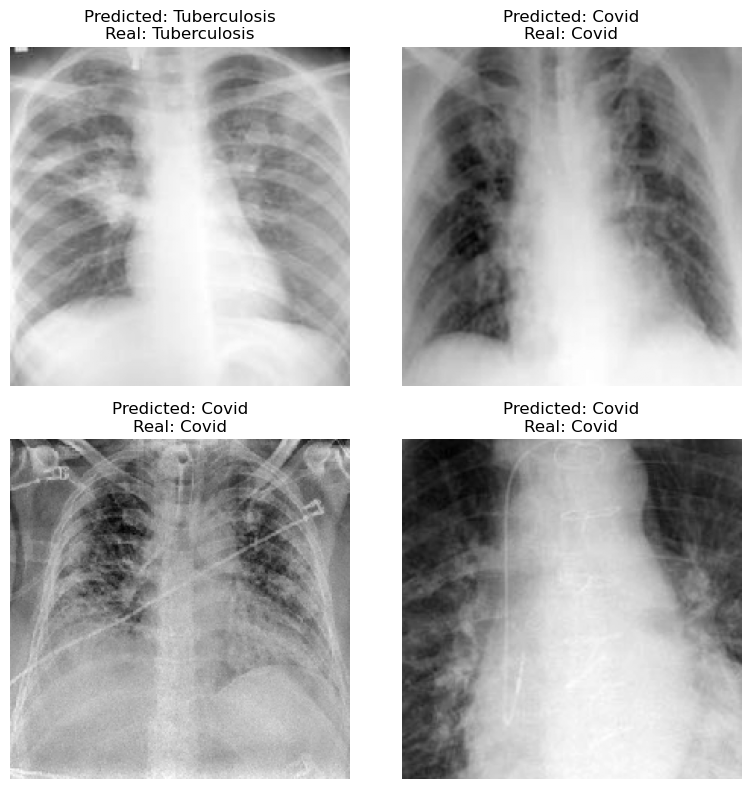

In [181]:
cls_names = {v: k for k, v in full_dataset.class_to_idx.items()}

plt.figure(figsize=(8, 8))

for i in range(samples_num // 2):
    plt.subplot(samples_num // 2, 2, 2 * i + 1)
    plt.imshow(images[2 * i].permute(1, 2, 0), cmap='gray')
    plt.title(
        f"Predicted: {cls_names[pred_labels[2 * i].item()]}\n"
        f"Real: {cls_names[real_labels[2 * i].item()]}"
    )
    plt.axis('off')

    plt.subplot(samples_num // 2, 2, 2 * i + 2)
    plt.imshow(images[2 * i + 1].permute(1, 2, 0), cmap='gray')
    plt.title(
        f"Predicted: {cls_names[pred_labels[2 * i + 1].item()]}\n"
        f"Real: {cls_names[real_labels[2 * i + 1].item()]}"
    )
    plt.axis('off')

plt.tight_layout()